# Exploring Machine Intelligence Week 4 _ homework1: modifying the autoencoder

## Experiments with Image Autoencoders 

***Note 1***

This notebook was originally written by Vit for the 2020 offering of Exploring Machine Intelligence. Vit in turn borrowed heavily from [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

***Note 2***

It is strongly recommended to run this on colab.google.com if you do not have a GPU.


# Step 0: Set everything up

In [ ]:
# Run this code without any changes
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Step 1: Load the data using Option 1 or Option 2 below. (Start with Option 1, then move onto Step 2)


### Option 1: Use MNIST digits (Start here first)

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
#original_dim = image_size * image_size
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = x_train[0].shape
x_train = np.reshape(x_train, x_train.shape+(1,))
x_test = np.reshape(x_test, x_test.shape+(1,))

print("We loaded the MNIST dataset:")
print("input_shape:", input_shape)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
We loaded the MNIST dataset:
input_shape: (28, 28)
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


(28, 28, 1) stats: 1.0 0.0 0.054706886


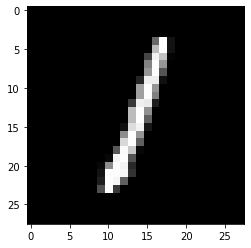

In [ ]:
# Let's look at one sample:
x1 = x_test[7000] #looks at the 9000th sample
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

#Show it as an image:
plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

### Option 2: Use QuickDraw (Do this only after you've done MNIST)

We can also use the QuickDraw [dataset](https://github.com/googlecreativelab/quickdraw-dataset) by [@Zaid Alyafeai](https://twitter.com/zaidalyafeai) which was used in the [ML4A guide](https://ml4a.github.io/guides/) for regular AutoEncoder.

In [ ]:
!git clone https://github.com/zaidalyafeai/QuickDraw10

Cloning into 'QuickDraw10'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [ ]:
import numpy as np

train_data = np.load('QuickDraw10/dataset/train-ubyte.npz')
test_data = np.load('QuickDraw10/dataset/test-ubyte.npz')

x_train, y_train = train_data['a'], test_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [ ]:
x_train = np.expand_dims(x_train.astype('float32') / 255. , 3)
x_test = np.expand_dims(x_test.astype('float32') / 255. , 3)
print (x_train.shape)
print (x_test.shape)

(80000, 28, 28, 1)
(20000, 28, 28, 1)


(28, 28, 1) stats: 1.0 0.0 0.8244548


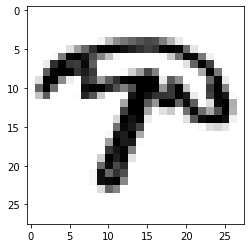

In [ ]:
# Let's look at one sample:
x1 = x_test[0] # 0 - umbrella
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

**Now that you've loaded the data, you can re-run the rest of the notebook to build a model, interpolate, etc!**

# Step 2: Now that you've loaded data (either MNIST or QuickDraw), do this to build the model:

Ensure that you've chosen either the MNIST or QuickDraw dataset above, and the dataset you want is now loaded into `x_train` and `x_test`.

This code builds a model using a standard convolutional autoencoder architecture:

Image -> Encoder -> latent vector representation -> Decoder -> Reconstruction

In [ ]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 128 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 128 #you could change this too

x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/8), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 28, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 16)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 32)   4640        ['max_pooling2d_3[0][0]']        
                                                                                            

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
#opt = RMSprop
vae.compile(optimizer='RMSprop')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        644160      ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    461633      ['encoder[0][2]']                
                                                                                            

In [ ]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/20
469/469 [==============================] - 20s 13ms/step - loss: 15.8088 - val_loss: 12.6965
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 11.2799 - val_loss: 10.8359
Epoch 3/20
469/469 [==============================] - 5s 12ms/step - loss: 10.5471 - val_loss: 10.2112
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 10.1445 - val_loss: 10.0215
Epoch 5/20
469/469 [==============================] - 6s 12ms/step - loss: 9.8937 - val_loss: 9.6567
Epoch 6/20
469/469 [==============================] - 5s 12ms/step - loss: 9.7281 - val_loss: 9.6580
Epoch 7/20
469/469 [==============================] - 5s 12ms/step - loss: 9.5871 - val_loss: 9.3645
Epoch 8/20
469/469 [==============================] - 5s 12ms/step - loss: 9.5018 - val_loss: 9.2654
Epoch 9/20
469/469 [==============================] - 5s 11ms/step - loss: 9.3973 - val_loss: 9.2187
Epoch 10/20
469/469 [==============================] - 5s 12ms/step - loss: 9.3282

In [ ]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/20
469/469 [==============================] - 7s 12ms/step - loss: 19.4065 - val_loss: 13.3350
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 11.6658 - val_loss: 11.1667
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 10.5962 - val_loss: 10.4725
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 10.1088 - val_loss: 10.1580
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 9.8155 - val_loss: 10.2781
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 9.6062 - val_loss: 10.1812
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 9.4770 - val_loss: 9.9692
Epoch 8/20
469/469 [==============================] - 5s 11ms/step - loss: 9.3276 - val_loss: 9.9462
Epoch 9/20
469/469 [==============================] - 5s 12ms/step - loss: 9.2497 - val_loss: 9.5595
Epoch 10/20
469/469 [==============================] - 5s 12ms/step - loss: 9.161

In [ ]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/20
469/469 [==============================] - 7s 11ms/step - loss: 22.3720 - val_loss: 15.6210
Epoch 2/20
469/469 [==============================] - 4s 10ms/step - loss: 13.0944 - val_loss: 13.0392
Epoch 3/20
469/469 [==============================] - 4s 10ms/step - loss: 11.6169 - val_loss: 11.5922
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 10.8678 - val_loss: 11.4087
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 10.4249 - val_loss: 11.2806
Epoch 6/20
469/469 [==============================] - 4s 9ms/step - loss: 10.1417 - val_loss: 10.7520
Epoch 7/20
469/469 [==============================] - 4s 9ms/step - loss: 9.9219 - val_loss: 10.6251
Epoch 8/20
469/469 [==============================] - 4s 9ms/step - loss: 9.7431 - val_loss: 9.7918
Epoch 9/20
469/469 [==============================] - 4s 9ms/step - loss: 9.6332 - val_loss: 10.5480
Epoch 10/20
469/469 [==============================] - 5s 10ms/step - loss: 9.5478 

In [ ]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/20
469/469 [==============================] - 14s 20ms/step - loss: 51.7276 - val_loss: 41.5757
Epoch 2/20
469/469 [==============================] - 9s 19ms/step - loss: 35.9363 - val_loss: 38.7182
Epoch 3/20
469/469 [==============================] - 9s 19ms/step - loss: 33.2322 - val_loss: 32.3363
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - loss: 31.8039 - val_loss: 32.2523
Epoch 5/20
469/469 [==============================] - 9s 19ms/step - loss: 30.9010 - val_loss: 29.2146
Epoch 6/20
469/469 [==============================] - 9s 19ms/step - loss: 30.2445 - val_loss: 29.0040
Epoch 7/20
469/469 [==============================] - 9s 20ms/step - loss: 29.7288 - val_loss: 28.3498
Epoch 8/20
469/469 [==============================] - 9s 19ms/step - loss: 29.3411 - val_loss: 28.0557
Epoch 9/20
469/469 [==============================] - 10s 20ms/step - loss: 29.0254 - val_loss: 27.6243
Epoch 10/20
469/469 [==============================] - 9s 20ms/step - 

Plot:


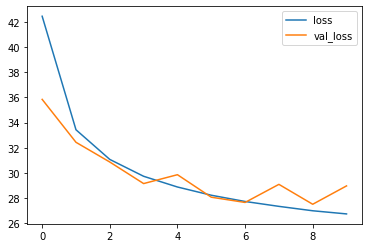

In [ ]:
# How did we go?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

^ the orginal polt

Plot:


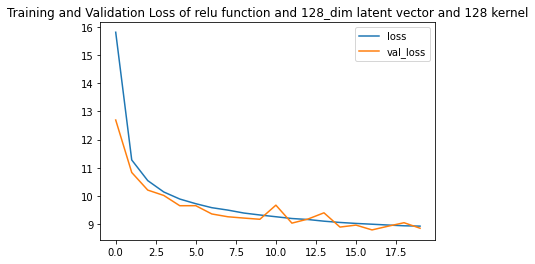

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.title('Training and Validation Loss of relu function and 128_dim latent vector and 128 kernel')
plt.legend()

print("Plot:")

Plot:


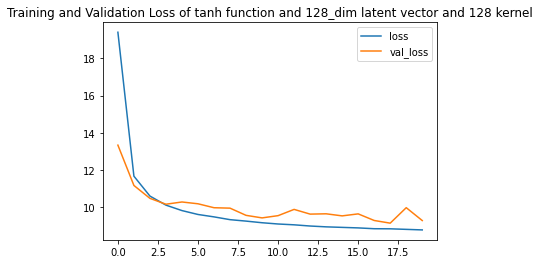

In [ ]:
# How did we go?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.title('Training and Validation Loss of tanh function and 128_dim latent vector and 128 kernel')
plt.legend()

print("Plot:")

Plot:


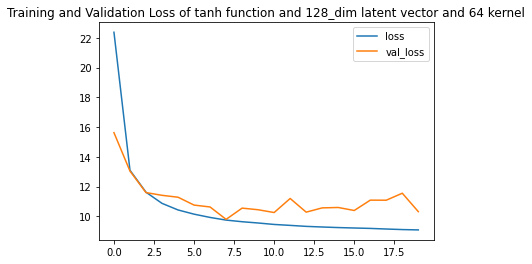

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.title('Training and Validation Loss of tanh function and 128_dim latent vector and 64 kernel')
plt.legend()

print("Plot:")

Plot:


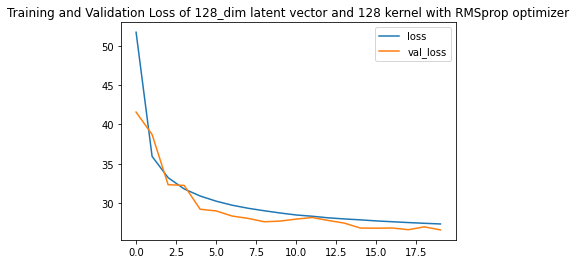

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.title('Training and Validation Loss of 128_dim latent vector and 128 kernel with RMSprop optimizer')
plt.legend()

print("Plot:")

In [ ]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

## Now let's use it!

In [ ]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

## Inspect one in detail:

(28, 28, 1)
1.0 0.0 0.147504


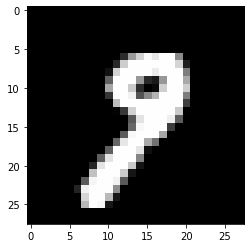

In [ ]:
# Encoded image:

x1 = x_test[73] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

(1, 128)
14.005387 -13.873772 -0.42254454


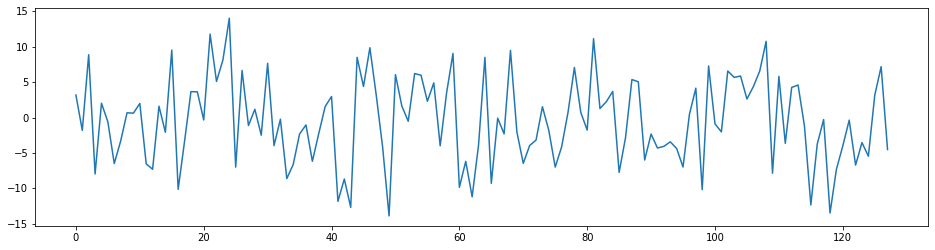

In [ ]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

(1, 128)
4.9021406 -2.497483 0.115833856


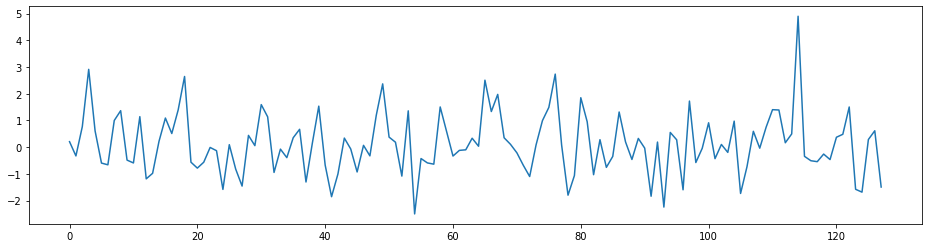

In [ ]:
x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

(1, 28, 28, 1)


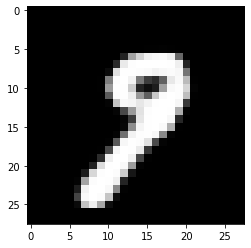

In [ ]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


(1, 28, 28, 1)


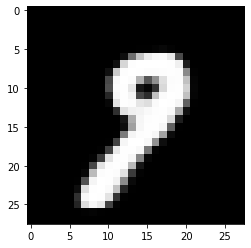

In [ ]:
y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

## Or in triplets:

In [ ]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

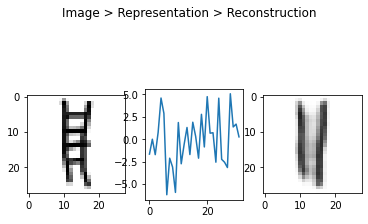

In [ ]:
x1 = x_test[9] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

### Look at a few randomly selected images and compare original, latent vector, and reconstruction

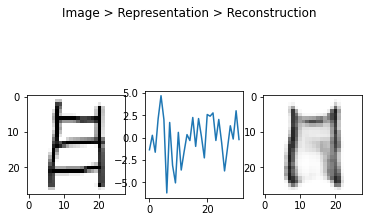

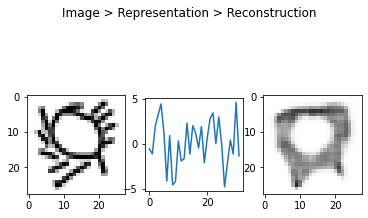

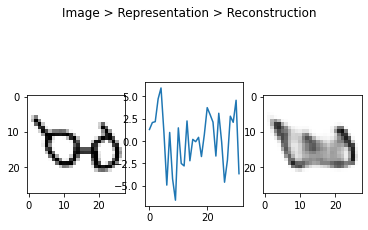

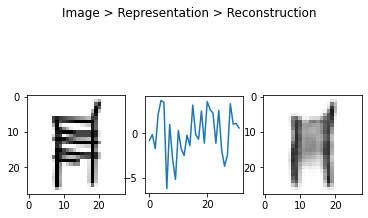

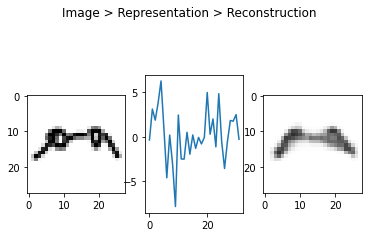

In [ ]:
from random import randrange
for i in range(5):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

### Show interpolation/moprhing between two images

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)


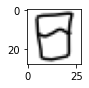

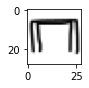

In [ ]:
sample_a = x_test[2] 
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[3] 
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)

#Let's show both original images 
plot_single(sample_a.reshape((28,28)))
plot_single(sample_b.reshape((28,28)))

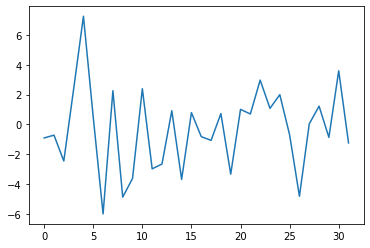

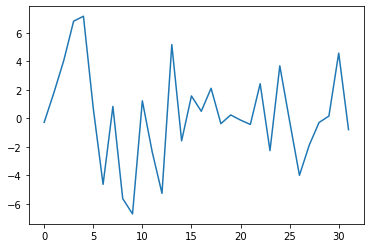

In [ ]:
# Show the latent vectors for each image
plt.plot(z_sample_a_encoded[0])
plt.show()
plt.plot(z_sample_b_encoded[0])
plt.show()

In [ ]:
# Define a function to linearly interpolate from one latent vector for another,
# specifically a*100% of the way there (i.e., if a=0.25, then we'll be 25% of the way from a to b)
def lerp(u,v,a):
    # linear interpolation between vectors u and v
    return a*u + (1-a)*v

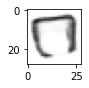

In [ ]:
a = 0.5  #show one image halfway between a and b
z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

0.0 :


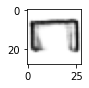

0.2 :


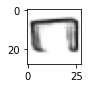

0.4 :


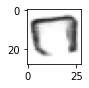

0.6 :


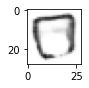

0.8 :


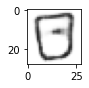

1.0 :


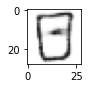

In [ ]:
# Now interpolate in a set number of steps
steps = 5
for i in range(steps + 1):
    # Goes from 0.0 to 1.0 in <steps> steps
    a_01 = float(i) / float(steps)
    z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a_01)
    y = decoder.predict(z_mix)
    image = y.reshape((28,28))
    print(a_01,":")
    plot_single(image)

## Produce a new image from a completely random latent vector

latent =  [[-4.07602231e+00  2.83167039e+00 -3.18532941e+00 -3.49759868e+00
  -9.92956591e-01  2.40504922e+00  4.29981404e+00 -4.80178055e+00
  -6.48918102e+00  1.04908366e+00  3.05672439e+00  7.37255397e+00
   5.88135798e-01 -4.69422018e+00 -6.07027783e-02 -8.41896065e-03
  -5.26209455e-03  9.15897178e+00  3.55358128e+00 -8.73485580e-01
  -4.56553853e+00  9.39973094e-01 -3.31234346e+00  2.44792494e+00
  -4.44252450e+00  7.38340697e-01  6.29823879e+00 -4.12244624e+00
   1.96788250e+00 -3.78668013e+00 -3.07805030e+00 -2.28804286e+00]]


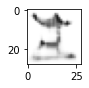

In [ ]:
# Random latent
latent = np.random.randn(1, 32) * 5
print("latent = ",latent)

image = decoder.predict(latent)
image = image.reshape((28,28))

plot_single(image)

latent =  [999.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


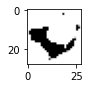

In [ ]:
# We can try to break it ...

latent = np.zeros(32)
latent[0] = 999.0 # oversaturated?
print("latent = ",latent)

image = decoder.predict(latent.reshape(1,32))
image = image.reshape((28,28))

plot_single(image)

## (Or) visualization as a gif:

As a bonus including a visualization from https://github.com/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb

First, you'll need to install `imageio` and `opencv-python` modules using pip or conda (see moodle instructions)

In [ ]:
import shutil 
import cv2
import imageio, glob

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1,_,_ = encoder.predict(x1) 
      v2,_,_ = encoder.predict(x2)
        
      #use a linear interpolater
      v = (float(x))*v1 + (1.0 - float(x))*v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [ ]:
!mkdir images
!ls images

mkdir: cannot create directory ‘images’: File exists
image0.png  image2.png	image4.png  image6.png	image8.png
image1.png  image3.png	image5.png  image7.png	image9.png


In [ ]:
interpolate(size = 10)

with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

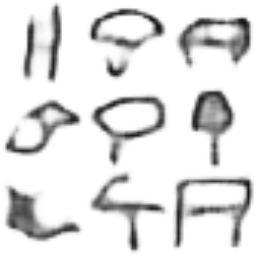

In [ ]:
from IPython import display 
display.Image(filename="lsi.gif.png")

## Activities to do on your own
1. (Easy) Try modifying the autoencoder or its training in at least one way that gives you a noticeable impact on the results. (e.g., change the optimiser, the number of kernels, the number of layers, the dimensionality of the latent vector, the activation function, etc.) How does this impact on the results? What changes did you try that did not impact the results noticably?
2. (More difficult) Try training this autoencoder on a new dataset. For instance, you might grab an existing image dataset from [https://www.kaggle.com/datasets?tags=13207-Computer+Vision](https://www.kaggle.com/datasets?tags=13207-Computer+Vision). You will have to tweak the code above if your images are a different size other than 28x28 (it's unwise to use images that are significantly bigger than this, though, unless you are willing to wait a while for training!)
3. (More difficult) Try building a version of Mario Klingemann's "X Degrees of Separation" for a dataset (could be MNIST or QuickDraw or something else). Write the code to select 5 (or some other number) of existing images that follow a smooth (as smooth as possible) path through latent space between two chosen images.

In [ ]:
!kaggle datasets download -d gpreda/chinese-mnist

 55% 9.00M/16.5M [00:01<00:01, 6.14MB/s]
100% 16.5M/16.5M [00:01<00:00, 11.4MB/s]


In [ ]:
!mv /content/kaggle.json /root/.kaggle

In [ ]:
!unzip /content/chinese-mnist.zip

In [ ]:
# _Read Images to Array from Folder

from PIL import Image
import os, os.path
import numpy as np

In [ ]:
# _Read Images to Array from Folder

imgs = []
labels = []

path = "/content/data/data"
valid_images = [".jpg",".gif",".png",".tga"]

for i,f in enumerate(os.listdir(path)):
  ext = os.path.splitext(f)[1]
  filename = os.path.splitext(f)[0]
  if ext.lower() not in valid_images:
      continue
  imgs.append(np.array(Image.open(os.path.join(path,f)).resize((28,28)))/255)
  labels.append(int(filename[-1]))
  
  if i%5000==0:
    print(f'processing index {i}')

img_data_x = np.expand_dims((np.array(imgs)),3)
img_data_y = np.array(labels)

print(f'collected data {img_data_x.shape}\ncollected label {img_data_y.shape}')

processing index 0
processing index 5000
processing index 10000
collected data (15000, 28, 28, 1)
collected label (15000,)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img_data_x, img_data_y, test_size=0.2, random_state=0)

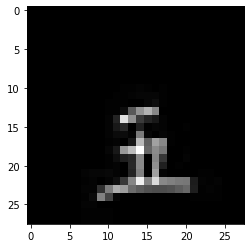

In [ ]:
plt.imshow(x_train[10,:,:,0], cmap='gray')

In [ ]:
# Run this code without any changes
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 128 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 64 #you could change this too

x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_35 (Conv2D)             (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_35[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 14, 14, 32)   9248        ['max_pooling2d_15[0][0]'] 

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        294560      ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    201121      ['encoder[0][2]']                
                                                                                            

In [ ]:
128*94

12032

In [ ]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/20
94/94 [==============================] - 7s 37ms/step - loss: 8.4610 - val_loss: 6.2137
Epoch 2/20
94/94 [==============================] - 3s 31ms/step - loss: 4.2202 - val_loss: 5.3610
Epoch 3/20
94/94 [==============================] - 3s 29ms/step - loss: 4.0571 - val_loss: 4.3333
Epoch 4/20
94/94 [==============================] - 3s 29ms/step - loss: 3.9786 - val_loss: 4.0032
Epoch 5/20
94/94 [==============================] - 3s 29ms/step - loss: 3.9258 - val_loss: 3.8725
Epoch 6/20
94/94 [==============================] - 3s 31ms/step - loss: 3.8814 - val_loss: 3.7925
Epoch 7/20
94/94 [==============================] - 3s 31ms/step - loss: 3.8419 - val_loss: 3.7381
Epoch 8/20
94/94 [==============================] - 3s 31ms/step - loss: 3.8082 - val_loss: 3.7307
Epoch 9/20
94/94 [==============================] - 3s 31ms/step - loss: 3.7754 - val_loss: 3.6746
Epoch 10/20
94/94 [==============================] - 3s 30ms/step - loss: 3.7462 - val_loss: 3.6452
Epoch 11/

Plot:


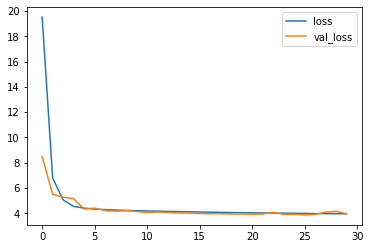

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

Plot:


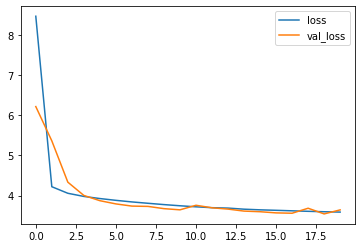

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [ ]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_Chinese_mnist')
save_model(decoder,'decoder_Chinese_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_Chinese_mnist')
encoder = my_load_model('encoder_Chinese_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

(28, 28, 1)
0.3333333333333333 0.0 0.013530412164865946


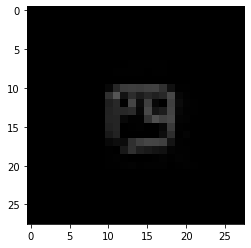

In [ ]:
# Encoded image:

x1 = x_test[276] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

(1, 128)
5.5447154 -6.002141 -0.16526741


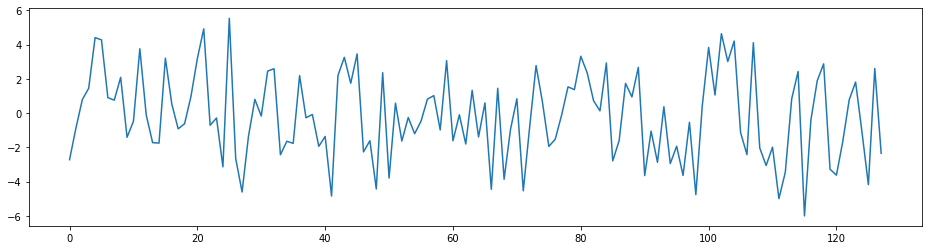

In [ ]:
x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

(1, 28, 28, 1)


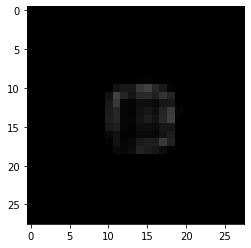

In [ ]:
y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

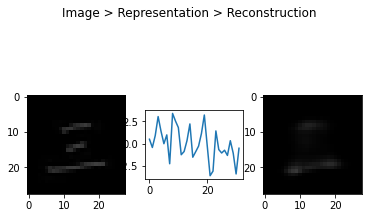

In [ ]:
x1 = x_test[46] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

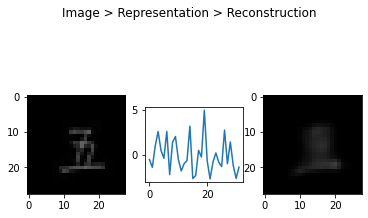

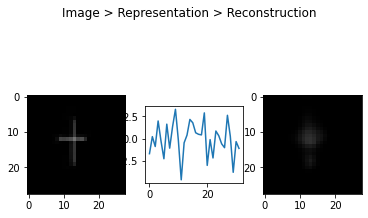

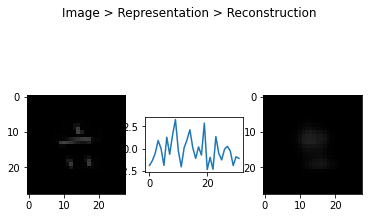

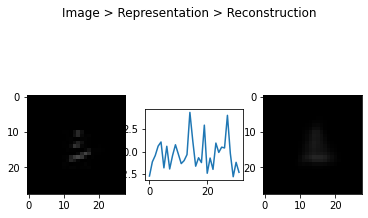

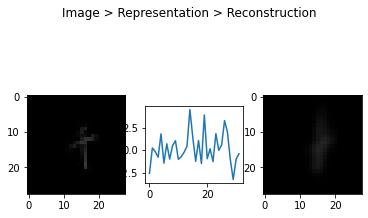

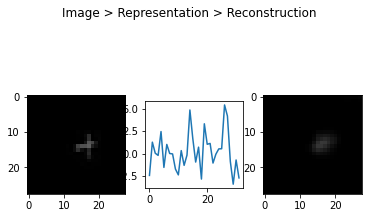

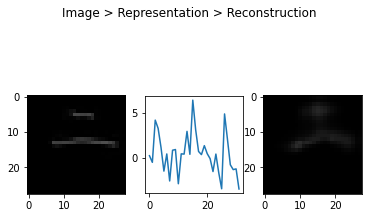

In [ ]:
from random import randrange
for i in range(7):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)


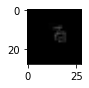

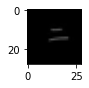

In [ ]:
sample_a = x_test[7] 
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[79] 
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)

#Let's show both original images 
plot_single(sample_a.reshape((28,28)))
plot_single(sample_b.reshape((28,28)))

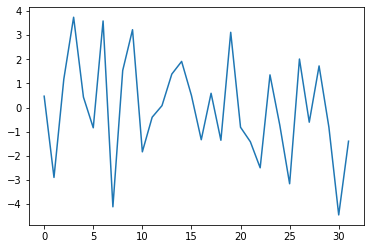

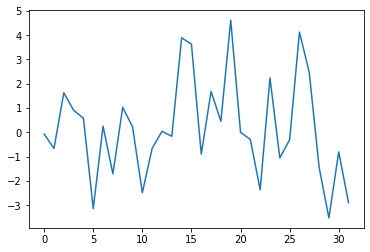

In [ ]:
# Show the latent vectors for each image
plt.plot(z_sample_a_encoded[0])
plt.show()
plt.plot(z_sample_b_encoded[0])
plt.show()

In [ ]:
def lerp(u,v,a):
    # linear interpolation between vectors u and v
    return a*u + (1-a)*v

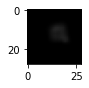

In [ ]:
a = 0.5  #show one image halfway between a and b
z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

0.0 :


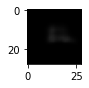

0.2 :


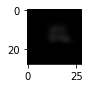

0.4 :


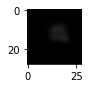

0.6 :


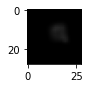

0.8 :


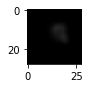

1.0 :


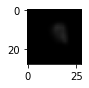

In [ ]:
steps = 5
for i in range(steps + 1):
    # Goes from 0.0 to 1.0 in <steps> steps
    a_01 = float(i) / float(steps)
    z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a_01)
    y = decoder.predict(z_mix)
    image = y.reshape((28,28))
    print(a_01,":")
    plot_single(image)

latent =  [[ 0.29957935 11.99532124  0.18931784 -4.68298795 -2.63823273  6.88007705
  -0.76791415 -2.03287422 -3.8717483   2.26964404  6.82489078 -5.00543042
  -5.2007433   9.24587015  2.89194445  1.37495228  6.74757068 -7.7549475
  -1.34922229 -2.80434564 -6.62723009  4.38320335  1.58836805  2.26583009
   1.02220416 -7.77254556  4.03833359  0.67974625 -5.79576287  5.57632608
  -3.15397756  7.89778176]]


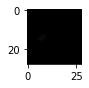

In [ ]:
# Random latent
latent = np.random.randn(1, 32) * 5
print("latent = ",latent)

image = decoder.predict(latent)
image = image.reshape((28,28))

plot_single(image)

latent =  [999.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


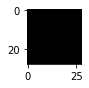

In [ ]:
# We can try to break it ...

latent = np.zeros(32)
latent[0] = 999.0 # oversaturated?
print("latent = ",latent)

image = decoder.predict(latent.reshape(1,32))
image = image.reshape((28,28))

plot_single(image)

In [ ]:
import shutil 
import cv2
import imageio, glob

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1,_,_ = encoder.predict(x1) 
      v2,_,_ = encoder.predict(x2)
        
      #use a linear interpolater
      v = (float(x))*v1 + (1.0 - float(x))*v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [ ]:
!mkdir images
!ls images

In [ ]:
interpolate(size = 10)

with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

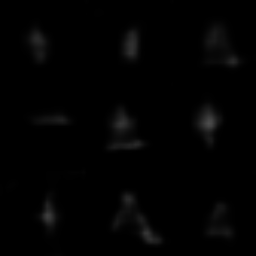

In [ ]:
from IPython import display 
display.Image(filename="lsi.gif.png")

1. changing the activition function

In [ ]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 32 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 26 #you could change this too

x = Conv2D(kernels, (3), activation='tanh', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("tanh")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='tanh')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("tanh")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='tanh', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='tanh', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='tanh')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         10615       ['encoder_input[0][0]']          
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    7900        ['encoder[0][2]']                
                                                                                            

In [ ]:
batch_size = 128
epochs = 30

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/30
94/94 [==============================] - 6s 24ms/step - loss: 28.9584 - val_loss: 6.6140
Epoch 2/30
94/94 [==============================] - 2s 19ms/step - loss: 5.9375 - val_loss: 5.1949
Epoch 3/30
94/94 [==============================] - 2s 19ms/step - loss: 5.1480 - val_loss: 4.8378
Epoch 4/30
94/94 [==============================] - 2s 19ms/step - loss: 4.7908 - val_loss: 4.6537
Epoch 5/30
94/94 [==============================] - 2s 19ms/step - loss: 4.6199 - val_loss: 4.5078
Epoch 6/30
94/94 [==============================] - 2s 19ms/step - loss: 4.5221 - val_loss: 4.3751
Epoch 7/30
94/94 [==============================] - 2s 19ms/step - loss: 4.4603 - val_loss: 4.3277
Epoch 8/30
94/94 [==============================] - 2s 19ms/step - loss: 4.4095 - val_loss: 4.2997
Epoch 9/30
94/94 [==============================] - 2s 19ms/step - loss: 4.3662 - val_loss: 4.2565
Epoch 10/30
94/94 [==============================] - 2s 19ms/step - loss: 4.3294 - val_loss: 4.2219
Epoch 11

Plot:


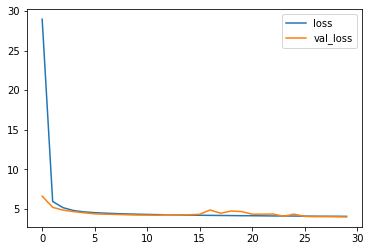

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [ ]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_Chinese_mnist_tanh')
save_model(decoder,'decoder_Chinese_mnist_tanh')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

In [ ]:
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_Chinese_mnist_tanh')
encoder = my_load_model('encoder_Chinese_mnist_tanh')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

(28, 28, 1)
0.3333333333333333 0.0 0.013530412164865946


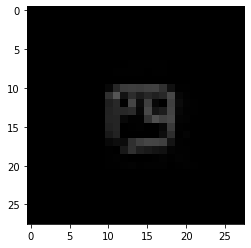

In [ ]:
x1 = x_test[276] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

(1, 32)
2.971041 -4.483725 -0.59297967


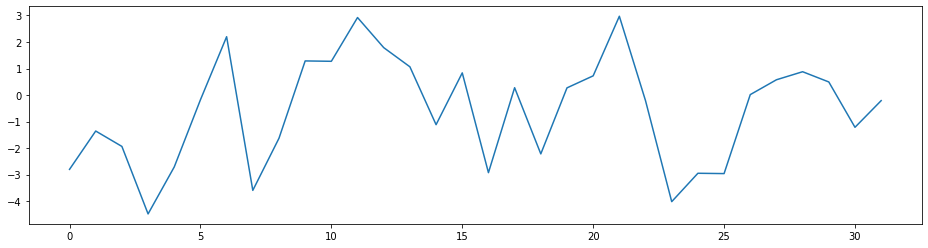

In [ ]:
x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

(1, 28, 28, 1)


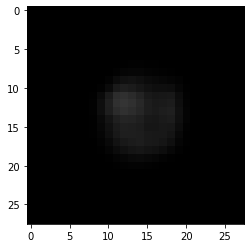

In [ ]:
y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

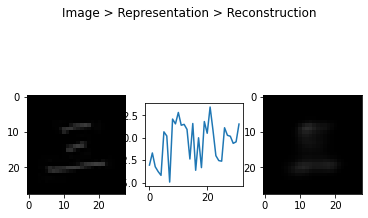

In [ ]:
x1 = x_test[46] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])